# 1. Preparação do ambiente

In [2]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from lightgbm import LGBMClassifier

# Pré-processamento
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Dark2')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../data/raw/telcocustomerchurn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 2. Preparação dos dados

In [4]:
# Primeiro vamos ajustar o target

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'].value_counts(1)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [5]:
# Também vamos tratar TotalCharges

df.TotalCharges = df.TotalCharges.replace(' ', np.nan)
df.TotalCharges = df.TotalCharges.astype(float)

## 2.1. Seleção das features

In [6]:
features = df.drop(columns = ['customerID', 'Churn'], axis = 1).columns.to_list()
target = 'Churn'

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(df[features], df[target], stratify=df[target], test_size=0.20, random_state=21)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=21)

## 2.2. Pré-processamento

In [8]:
cat_features = X_train.select_dtypes(include = 'object').columns.to_list()
num_features = X_train.select_dtypes(include = 'number').columns.to_list()

In [9]:
cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('encoding', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

In [10]:
# Vamos ajustar os pesos da classes

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

# 3. Modelo de Classificação

## 3.1. Modelo base

In [11]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=21, class_weight = weights_dict))
])

clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1123, number of negative: 3102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoding',
                                                                   TargetEncoder())]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier',
                 LGBMClassifier(class_weight={0: 0.6810122501611864,
                                              1: 1.8811219946571682},
                                random_state=21))])

In [12]:
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]

In [13]:
print(f"Métricas de Validação (base)")
print("=" * 30)
print(f"Recall: {metrics.recall_score(y_val, y_pred)}")
print(f"Precision: {metrics.precision_score(y_val, y_pred)}")
print(f"F1 Score: {metrics.f1_score(y_val, y_pred)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_val, y_proba)}")

Métricas de Validação (base)
Recall: 0.7231182795698925
Precision: 0.5860566448801743
F1 Score: 0.6474127557160048
ROC AUC: 0.8504279818749286


In [14]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1037
           1       0.59      0.72      0.65       372

    accuracy                           0.79      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.79      0.80      1409



O modelo base apresentou boas métricas, para Churn a sensibilidade (Recall) que costuma ser a métrica mais importante, nestes casos é mais critico identificar corretamente os verdadeiros positivos, mesmo que isso leve a mais casos de falsos positivos. Como visto na EDA, clientes que passam mais tempo com contrato ativo na Telco trazem maior receita total ao longo do tempo, portanto buscar ao máximo a retenção de clientes deve ser o foco. 

## 3.2. Tunagem dos hiper-parâmetros

In [15]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',LGBMClassifier(
        verbosity = -1,
        n_estimators = 5000,
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        num_leaves = trial.suggest_int("num_leaves", 2, 2**10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100),
        class_weight=weights_dict,
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    f1score = metrics.f1_score(y_val, predictions)
    return f1score

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-13 16:02:26,314] A new study created in memory with name: no-name-14757689-3236-4aa6-b385-dda0863093cf
[I 2024-08-13 16:02:38,375] Trial 0 finished with value: 0.5459770114942529 and parameters: {'learning_rate': 0.03802920466119113, 'num_leaves': 929, 'subsample': 0.46955784131047085, 'colsample_bytree': 0.6423779717558257, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.5459770114942529.
[I 2024-08-13 16:02:47,181] Trial 1 finished with value: 0.5764075067024129 and parameters: {'learning_rate': 0.011859505796601574, 'num_leaves': 568, 'subsample': 0.8119908031096633, 'colsample_bytree': 0.43254101945804596, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.5764075067024129.
[I 2024-08-13 16:02:55,160] Trial 2 finished with value: 0.6208588957055214 and parameters: {'learning_rate': 0.0026479343563263684, 'num_leaves': 234, 'subsample': 0.07825321361710004, 'colsample_bytree': 0.4660423792958576, 'min_data_in_leaf': 51}. Best is trial 2 with value: 0.6208588957

In [17]:
print('Melhores hiper-parâmetros:', study.best_params)
print('Melhor F1 Score:', study.best_value)

Melhores hiper-parâmetros: {'learning_rate': 0.00132604522845685, 'num_leaves': 54, 'subsample': 0.7445668806559453, 'colsample_bytree': 0.6826328010246474, 'min_data_in_leaf': 87}
Melhor F1 Score: 0.6475315729047072


In [18]:
clf_op = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**study.best_params, class_weight=weights_dict, n_estimators = 5000, random_state = 21))
])

clf_op.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoding',
                                                                   TargetEncoder())]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMo...
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier',
                 LGBMClassifier(class_weight={0: 0.6810122501611864,
                                              1: 1.8811219946571682},
                                colsample_bytree=0.6826328010246474,
                                learning_rate=0.00132604522845685,
                                min_data_in_leaf=87, n_estimators=5000,
                                num_leaves=54, random_state=21,
                                subsample=0.7445668806559453))])

In [19]:
y_pred_op = clf_op.predict(X_val)
y_proba_op = clf_op.predict_proba(X_val)[:,1]

In [20]:
print(f"Métricas de Validação (otimizado)")
print("=" * 30)
print(f"Recall: {metrics.recall_score(y_val, y_pred_op)}")
print(f"Precision: {metrics.precision_score(y_val, y_pred_op)}")
print(f"F1 Score: {metrics.f1_score(y_val, y_pred_op)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_val, y_proba_op)}")

Métricas de Validação (otimizado)
Recall: 0.7580645161290323
Precision: 0.5651302605210421
F1 Score: 0.6475315729047072
ROC AUC: 0.8545315270476251


In [21]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1037
           1       0.59      0.72      0.65       372

    accuracy                           0.79      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.79      0.80      1409



In [22]:
print(metrics.classification_report(y_val, y_pred_op))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1037
           1       0.57      0.76      0.65       372

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



## 3.3. Avaliando resultados: Validação x Teste

In [23]:
y_proba = clf_op.predict_proba(X_val)[:,1]
y_pred = (y_proba > 0.5).astype(int)

y_proba_test = clf_op.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test > 0.5).astype(int)

In [24]:
print(f"Métricas de Validação")
print("=" * 30)
print(f"Recall: {metrics.recall_score(y_val, y_pred)}")
print(f"Precision: {metrics.precision_score(y_val, y_pred)}")
print(f"F1 Score: {metrics.f1_score(y_val, y_pred)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_val, y_proba)}")

Métricas de Validação
Recall: 0.7580645161290323
Precision: 0.5651302605210421
F1 Score: 0.6475315729047072
ROC AUC: 0.8545315270476251


In [25]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1037
           1       0.57      0.76      0.65       372

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



In [26]:
print(f"Métricas de Teste")
print("=" * 30)
print(f"Recall: {metrics.recall_score(y_test, y_pred_test)}")
print(f"Precision: {metrics.precision_score(y_test, y_pred_test)}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_test)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_test, y_proba_test)}")

Métricas de Teste
Recall: 0.7352941176470589
Precision: 0.5248091603053435
F1 Score: 0.6124721603563474
ROC AUC: 0.8330620785863753


In [27]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.75      0.76      1409



In [28]:
scoring = metrics.make_scorer(metrics.recall_score)
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=21)

scores = cross_val_score(clf_op, X_train, y_train, cv = cv, scoring = scoring)
print(f'Média da sensibilidade: {scores}')
print(f'Média da sensibilidade geral: {scores.mean()}')
print(f'Desvio padrão da sensibilidade: {scores.std()}')

Média da sensibilidade: [0.76888889 0.74666667 0.73777778 0.80357143 0.74553571]
Média da sensibilidade geral: 0.7604880952380952
Desvio padrão da sensibilidade: 0.02390443911964033


In [29]:
curva = metrics.roc_curve(y_test, y_proba_test)

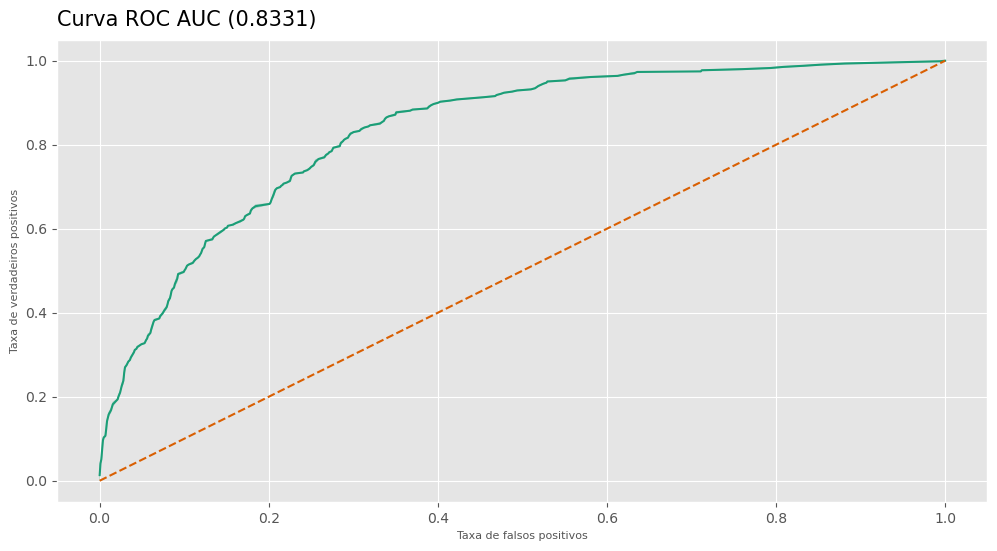

In [30]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curva[0], y = curva[1])
sns.lineplot(x = [0, 1], y = [0, 1], markers = True, linestyle = '--')
ax.set_title(f"Curva ROC AUC ({metrics.roc_auc_score(y_test, y_proba_test):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Taxa de falsos positivos", fontsize = 8)
ax.set_ylabel("Taxa de verdadeiros positivos", fontsize = 8)
plt.show()

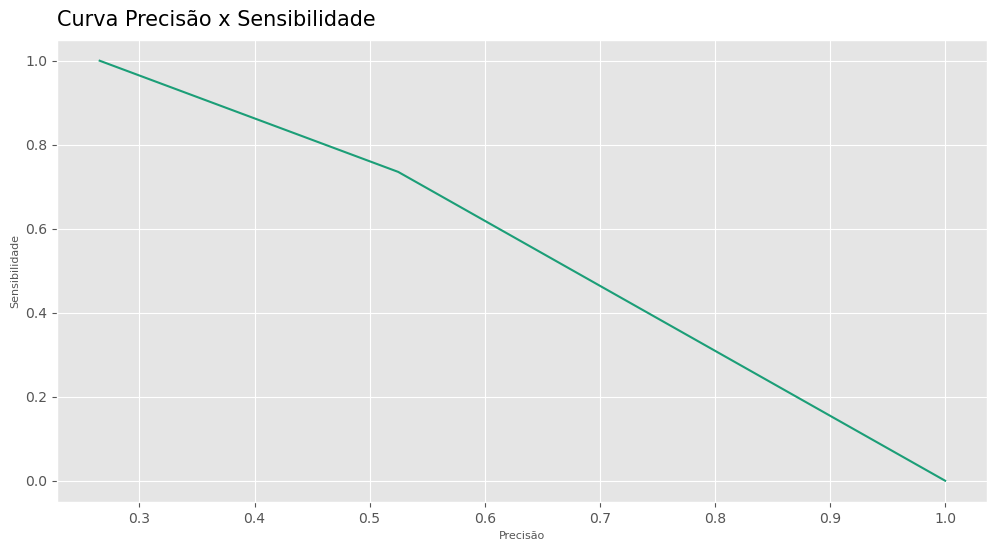

In [31]:
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pred_test)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Curva Precisão x Sensibilidade", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Precisão", fontsize = 8)
ax.set_ylabel("Sensibilidade", fontsize = 8)
plt.show()


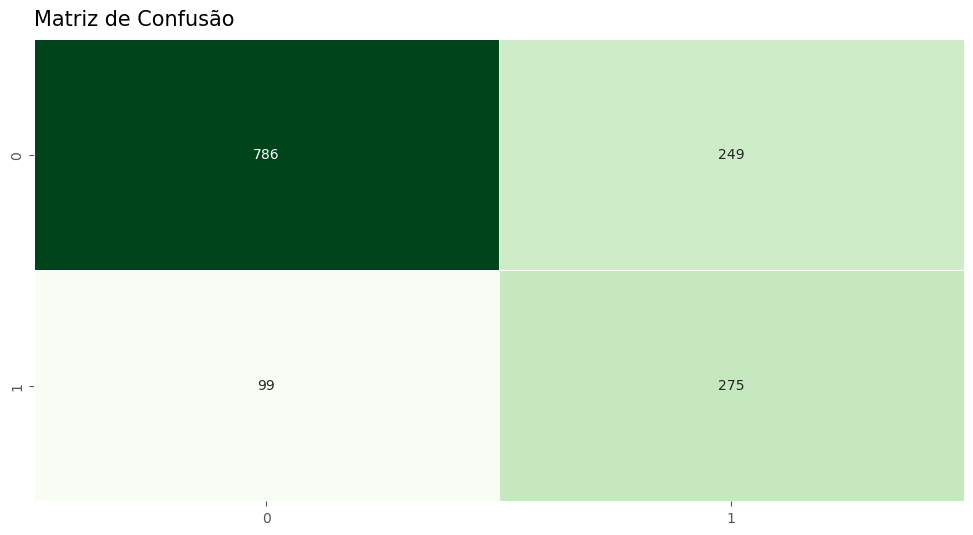

In [32]:
cf = metrics.confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(cf, annot = True, fmt = '.0f', linewidths=0.5,cbar = False, cmap = 'Greens')
ax.set_title("Matriz de Confusão", fontsize = 15, pad = 10, loc = 'left')
plt.show()

#### Conclusões

Conseguimos ao fim um modelo com boa capacidade de generalização, mostrando pouca variância na sensibilidade durante a validação cruzada. 